### Importing Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Importing a sheet music

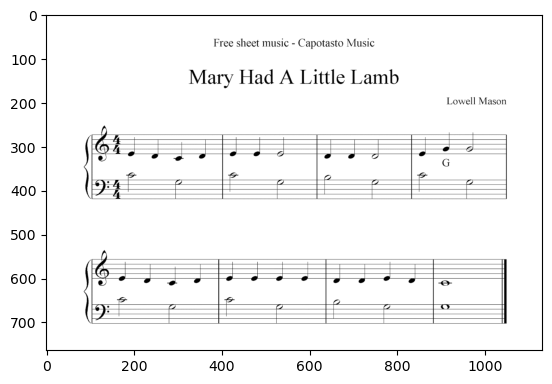

In [2]:
sheetmusic = cv2.cvtColor(cv2.imread('../Images/sheet_musics/Mary_had_a_little_lamb.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(sheetmusic, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()

### Segmentation and Preprocessing
Steps
------
- Erosion using horizontal line of 1/5 of the image width
- Row sum has been done to get a 1D vector
- Eroded with vertical lines of variable length
- Dividers are calculated by taking the middle of the black portions
- Staff lines are identified by thresholding the row sums. Before that opening and closing are used to make the staff  lines smooth
- Staff lines are removed for further processing

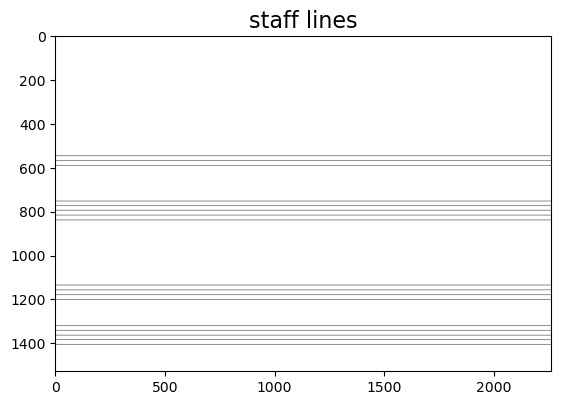

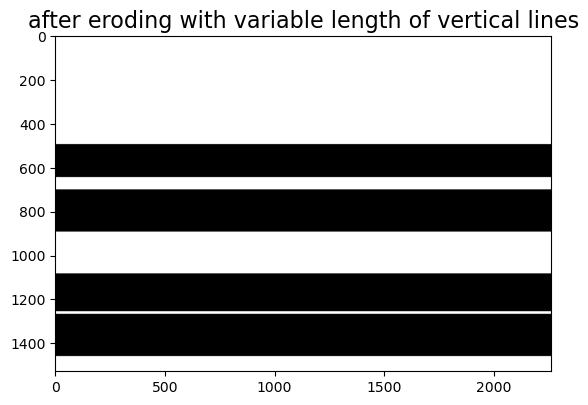

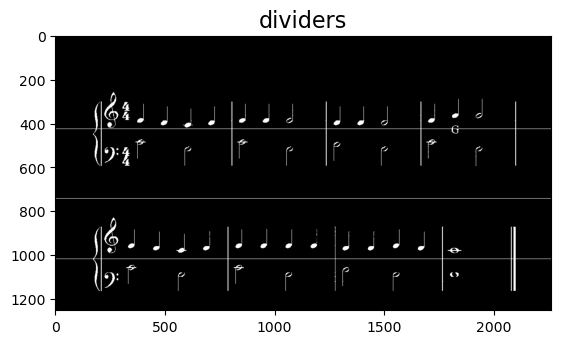

In [35]:
results_path = "../Images/results/"

def join_segments(segments):
    x = []
    for i, segment in enumerate(segments):
        x.append(segment)
        if i < len(segments) - 1:
            x.append(255 * np.ones((2,) + segment.shape[1:]).astype(np.uint8))
    return np.concatenate(x, axis = 0)

def segmentation_and_preprocessing(sheetmusic):
    _, sheetmusic = cv2.threshold(sheetmusic, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    sheetmusic = sheetmusic.repeat(2, axis = 0).repeat(2, axis = 1)

    intermediate_steps = []

    horizontal_line = 255 * np.ones((1, int(sheetmusic.shape[1] // 5)))
    staff_lines = cv2.erode(sheetmusic, horizontal_line)
    staff_lines_vector = np.sum(staff_lines, axis = 1) / sheetmusic.shape[1]
    staff_lines_vector = (staff_lines_vector * 255 / (np.max(staff_lines_vector) - np.min(staff_lines_vector))).astype(np.uint8)
    staff_lines_vector = cv2.threshold(staff_lines_vector, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1].T
    intermediate_steps.append((np.repeat(staff_lines_vector.T, sheetmusic.shape[1], axis = 1), "staff lines"))

    # staff_lines_vector_eroded : shape(1, sheetmusic.shape[0])
    staff_lines_vector_eroded = np.zeros(staff_lines_vector.shape, dtype = np.float64)
    for vh in range(1, sheetmusic.shape[1] // 12):
        vertical_line = 255 * np.ones((1, vh))
        # print(staff_lines_vector.shape, vertical_line.shape)
        staff_lines_vector_eroded += cv2.erode(staff_lines_vector, vertical_line)
    staff_lines_vector_eroded = (staff_lines_vector_eroded / (sheetmusic.shape[1] // 12 + 1)).astype(np.uint8)
    staff_lines_vector_eroded = cv2.threshold(staff_lines_vector_eroded, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    intermediate_steps.append((np.repeat(staff_lines_vector_eroded.T, sheetmusic.shape[1], axis = 1), "after eroding with variable length of vertical lines"))

    dividers = []; l = None
    for i, intensity in enumerate(staff_lines_vector_eroded[0]):
        if l == None:
            if intensity == 255:
                l = i
        else:
            if intensity == 0:
                dividers.append(l + (i - 1 - l) // 2)
                l = None
    dividers.append(l + (i - 1 - l) // 2)
    dividers_display = np.zeros(sheetmusic.shape)
    for x in dividers:
        dividers_display[x - 1] = 255 * np.ones((sheetmusic.shape[1],))
        dividers_display[x] = 255 * np.ones((sheetmusic.shape[1],))
        dividers_display[x + 1] = 255 * np.ones((sheetmusic.shape[1],))
    # intermediate_steps.append((dividers_display, ""))

    segments = [{'music_piece': sheetmusic[dividers[i]: dividers[i + 1]]} for i in range(len(dividers) - 1)]

    for segment_id, segment in enumerate(segments):
        segment_staff_lines_vector = (np.sum(segment['music_piece'], axis = 1) / segment['music_piece'].shape[1]).astype(np.uint8)
        segment_staff_lines = cv2.morphologyEx(segment['music_piece'], cv2.MORPH_CLOSE, 255 * np.ones((1, sheetmusic.shape[1] // 100)))
        segment_staff_lines = cv2.morphologyEx(segment_staff_lines, cv2.MORPH_OPEN, horizontal_line)
        segment_staff_lines_vector[segment_staff_lines_vector > 127] = 255
        x = np.where(segment_staff_lines_vector == 255)[0]
        segment_staff_lines_indices = [x[i] for i in range(len(x)) if (i == 0 or x[i] - x[i - 1] > 3)]
        segment_staff_lines_space = int(np.mean([segment_staff_lines_indices[i + 1] - segment_staff_lines_indices[i] for i in range(len(segment_staff_lines_indices) - 1)]))
        segment_staff_lines_c = segment_staff_lines_indices[-1] + segment_staff_lines_space
        segment['staff_lines'] = {'c': segment_staff_lines_c, 'space': segment_staff_lines_space}
        
        segment['music_piece'] -= segment_staff_lines
        for segment_staff_lines_index in segment_staff_lines_indices:
            segment['music_piece'][segment_staff_lines_index] = np.zeros(segment['music_piece'][segment_staff_lines_index].shape)
        segment['music_piece'] = cv2.morphologyEx(segment['music_piece'], cv2.MORPH_CLOSE, np.ones((int(segment_staff_lines_space / 7), 2)))

        segment['music_piece'][:max(segment_staff_lines_c - 10 * segment_staff_lines_space, 0)] = 0

    intermediate_steps.append((join_segments([segment['music_piece'] for segment in segments]), "dividers"))
    return intermediate_steps, segments

intermediate_steps, sheetmusic_segments = segmentation_and_preprocessing(sheetmusic)

# fig, ax = plt.subplots(len(intermediate_steps), 1, figsize = (15, 8 * len(intermediate_steps)))
for i in range(len(intermediate_steps)):
    plt.imshow(intermediate_steps[i][0], cmap = 'gray', vmin = 0, vmax = 255)
    plt.title(intermediate_steps[i][1], fontsize = 16)
    plt.show()
    # plt.savefig(results_path + f"{i + 1}. segmentation_" + intermediate_steps[i][1] + '.png')

# if type(sheetmusic_segments) == np.ndarray:
#     fig, ax = plt.subplots(1, 1, figsize = (15, 5))
#     ax.imshow(sheetmusic_segments, cmap = 'gray', vmin = 0, vmax = 255)
# else:
#     segments_joined = join_segments([segment['music_piece'] for segment in sheetmusic_segments])
#     fig, ax = plt.subplots(1, 1, figsize = (15, 4 * len(sheetmusic_segments)))
#     ax.imshow(segments_joined, cmap = 'gray', vmin = 0, vmax = 255)

### Some values used for template matching

In [15]:
treble_clef_space_ratio = 7.857143
treble_clef_threshold = 6000

bass_clef_space_ratio = 3.57142
bass_clef_threshold = 6000

quarter_note_space_ratio = 1.0
quarter_note_threshold = 0.61

half_note_space_ratio = 1.0
half_note_threshold = 0.48

# whole_note_space_ratio = 0.78125
# whole_note_threshold = 0.48

notations_path = './data/notations'

### Clef detection

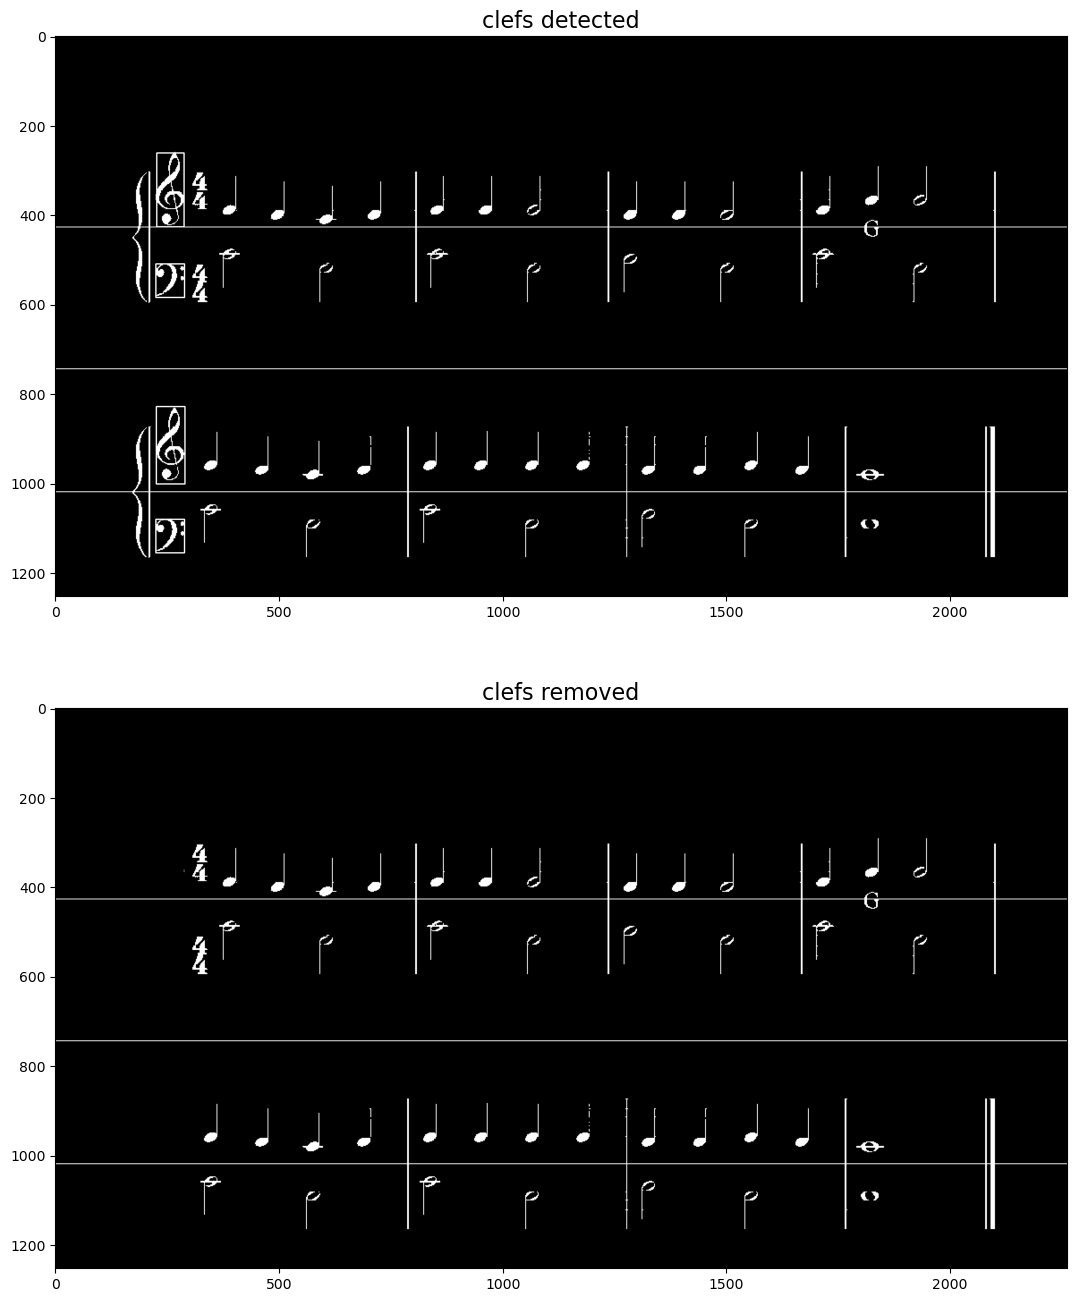

In [36]:
def clef_detection(sheetmusic_segments, notations_path):
    treble_clef = cv2.cvtColor(cv2.imread(notations_path + '/treble_clef.png'), cv2.COLOR_BGR2GRAY)
    _, treble_clef = cv2.threshold(treble_clef, 0, 255, cv2.THRESH_OTSU)
    bass_clef = cv2.cvtColor(cv2.imread(notations_path + '/bass_clef.png'), cv2.COLOR_BGR2GRAY)
    _, bass_clef = cv2.threshold(bass_clef, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    clefs_annotated = []
    
    for segment in sheetmusic_segments:
        segment['clef'] = None
        img = segment['music_piece'].copy()
        
        fy = treble_clef_space_ratio * segment['staff_lines']['space'] / treble_clef.shape[0]
        template = cv2.resize(treble_clef, (0, 0), fx = fy, fy = fy)
        width, height = template.shape[::-1]
        method = cv2.TM_CCOEFF
        res = cv2.matchTemplate(img,template,method)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        max_val /= np.prod(template.shape)
        if segment['clef'] is None and max_val > treble_clef_threshold:
            segment['clef'] = {}
            top_left = max_loc[::-1]
            segment['clef']['type'] = 'treble'
            segment['clef']['loc'] = {}
            segment['clef']['loc']['top_left'] = top_left
            segment['clef']['loc']['width'] = width
            segment['clef']['loc']['height'] = height
            
            top_left = max_loc
            bottom_right = (top_left[0] + width, top_left[1] + height)
            cv2.rectangle(img, top_left, bottom_right, 255, 2)

        fy = bass_clef_space_ratio * segment['staff_lines']['space'] / bass_clef.shape[0]
        template = cv2.resize(bass_clef, (0, 0), fx = fy, fy = fy)
        width, height = template.shape[::-1]
        method = cv2.TM_CCOEFF
        res = cv2.matchTemplate(img,template,method)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        max_val /= np.prod(template.shape)
        if segment['clef'] is None and max_val > bass_clef_threshold:
            segment['clef'] = {}
            top_left = max_loc[::-1]
            segment['clef']['type'] = 'bass'
            segment['clef']['loc'] = {}
            segment['clef']['loc']['top_left'] = top_left
            segment['clef']['loc']['width'] = width
            segment['clef']['loc']['height'] = height
            
            top_left = max_loc
            bottom_right = (top_left[0] + width, top_left[1] + height)
            cv2.rectangle(img, top_left, bottom_right, 255, 2)

        if segment['clef'] is not None:
            segment['music_piece'][:, :segment['clef']['loc']['top_left'][1] + segment['clef']['loc']['width']] = 0
            if segment['clef']['type'] == 'bass':
                segment['staff_lines']['c'] -= 6 * segment['staff_lines']['space']
        
        clefs_annotated.append(img)
            
    return clefs_annotated
            

clefs_annotated = clef_detection(sheetmusic_segments, notations_path)

if type(sheetmusic_segments) == np.ndarray:
    fig, ax = plt.subplots(1, 1, figsize = (15, 5))
    ax.imshow(sheetmusic_segments, cmap = 'gray', vmin = 0, vmax = 255)
else:
    segments_joined = join_segments([segment['music_piece'] for segment in sheetmusic_segments])
    clefs_annotated_joined = join_segments(clefs_annotated)
    fig, ax = plt.subplots(2, 1, figsize = (15, 4 * len(sheetmusic_segments)))
    ax[0].imshow(clefs_annotated_joined, cmap = 'gray', vmin = 0, vmax = 255)
    ax[0].set_title("clefs detected", fontsize = 16)
    ax[1].imshow(segments_joined, cmap = 'gray', vmin = 0, vmax = 255)
    ax[1].set_title("clefs removed", fontsize = 16)
    fig.savefig(results_path + 'clef_detection.png')

### Notes detection

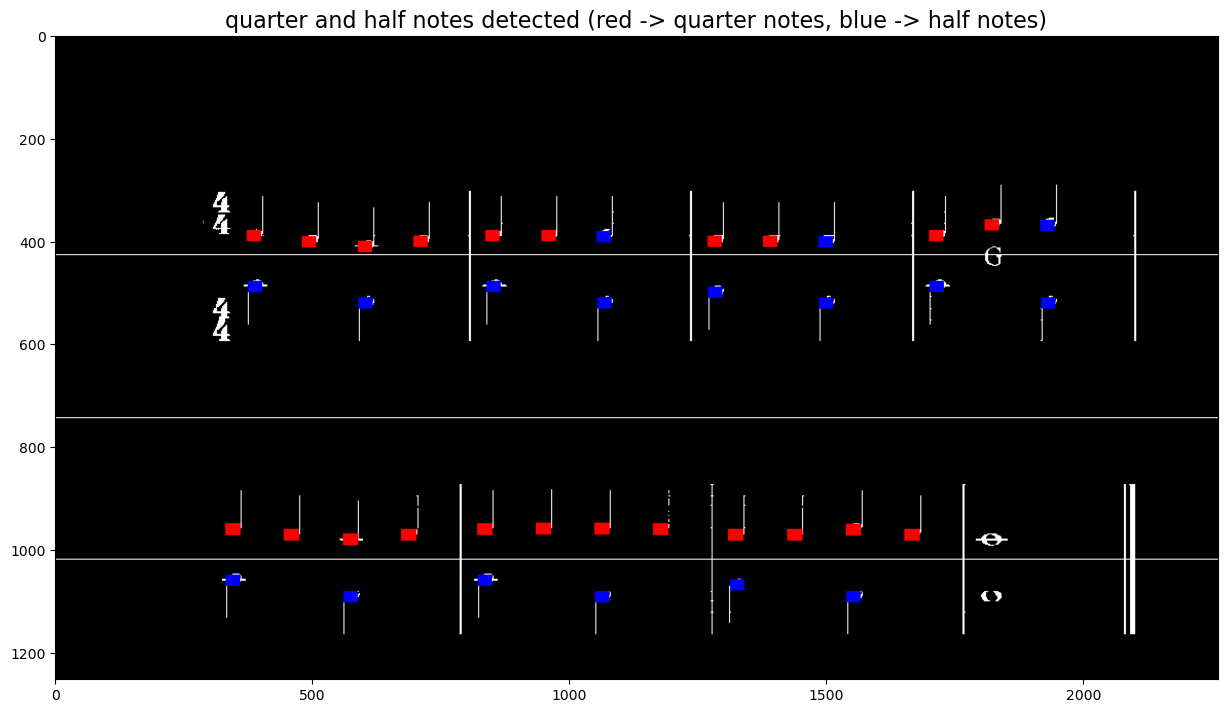

In [40]:
def notes_detection(sheetmusic_segments, notations_path):
    quarter_note = cv2.cvtColor(cv2.imread(notations_path + '/quarter_note.png'), cv2.COLOR_BGR2GRAY)
    _, quarter_note = cv2.threshold(quarter_note, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    half_note = cv2.cvtColor(cv2.imread(notations_path + '/half_note_middle_line.png'), cv2.COLOR_BGR2GRAY)
    _, half_note = cv2.threshold(half_note, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    note_templates = [quarter_note, half_note]
    notes_duration = [0.25, 0.5]
    note_thresholds = [quarter_note_threshold, half_note_threshold]
    notes_names = ['1/4', '1/2']
    notes_colors = [[255, 0, 0], [0, 0, 255]]
    
    notes_annotated = []
    
    for segment in sheetmusic_segments:
        notes_loc = []
        img = segment['music_piece'].copy()
        img_annotated = np.repeat(img, 3).reshape(img.shape + (3,))
        for note_template, note_duration, note_threshold, note_name, note_color in zip(note_templates, notes_duration, note_thresholds, notes_names, notes_colors):
            fy = quarter_note_space_ratio * segment['staff_lines']['space'] / note_template.shape[0]
            note_template = cv2.resize(note_template, (0, 0), fx = fy, fy = fy)
            w, h = note_template.shape[::-1]
            method = cv2.TM_CCOEFF_NORMED
            
            res = cv2.matchTemplate(img, note_template, method)
            threshold = 0.65
            loc = np.where(res >= note_threshold)
            loc = sorted(list(zip(loc[1], loc[0] + h / 2)))
            loc = [loc[i] for i in range(len(loc)) if (i == 0 or loc[i][0] - loc[i - 1][0] > 5)]
            notes_loc.extend([x + (note_duration,) for x in loc])
            for x in loc:
                # top_left = (x[0], int(x[1] - h / 2))
                # bottom_right = (top_left[0] + w, top_left[1] + h)
                # cv2.rectangle(img_annotated, top_left, bottom_right, note_color, 2)
                top_left = (int(x[1] - h / 2), x[0])
                bottom_right = (top_left[0] + h, top_left[1] + w)
                img_annotated[top_left[0]:bottom_right[0] + 1, top_left[1]:bottom_right[1] + 1] = note_color
        notes_loc.sort()
        notes = [(round((segment['staff_lines']['c'] - note_loc[1]) * 2 / segment['staff_lines']['space'] ), note_loc[2])  for note_loc in notes_loc]
        notes_loc = [((round(x[1] - h/2), x[0]), (h, w), note_name) for x in notes_loc]
        segment['notes'] = notes
        segment['notes_loc'] = notes_loc

        notes_annotated.append(img_annotated)
    return notes_annotated        

notes_annotated = notes_detection(sheetmusic_segments, notations_path)
notes_annotated_joined = join_segments(notes_annotated)
fig, ax = plt.subplots(1, 1, figsize = (15, 4 * len(sheetmusic_segments)))
ax.imshow(notes_annotated_joined, cmap = 'gray', vmin = 0, vmax = 255)
ax.set_title("quarter and half notes detected (red -> quarter notes, blue -> half notes)", fontsize = 16)
# plt.show()
plt.savefig(results_path + 'notes_detection.png')